In [1]:
import geopandas as gp
import pandas as pd
import numpy as np
from scipy.stats import linregress
import subprocess
import os,sys
import emcee
import statsmodels.api as sm
import pylab
from scipy.stats import norm
import seaborn as sn
import corner
from scipy import optimize,linalg
import matplotlib.pyplot as plt
import multiprocessing 

def shell(cmd):
    #print(cmd)
    process = subprocess.Popen([sys.executable]+cmd.split(" "),
                     stdout=subprocess.PIPE, 
                     stderr=subprocess.PIPE,text=True)
    stdout, stderr = process.communicate()
    if not process.returncode==0:
        try:
            print(cmd)
            print(stdout)
            print(stderr)
        except:
            print("failed to decode stdout/stderr")
        return False
    #print(stdout)
    return True



In [2]:
import numpy as np
import torch
torch.from_numpy(np.array([]))

tensor([], dtype=torch.float64)

In [18]:
input_nets = {"a470":"../data/a470_test_prep.shp"
              }
def test_drape(input_net,spatial_mismatch_prior_scale,slope_prior_scale,slope_continuity_prior_scale,pitch_angle_prior_scale,refresh=True):
    input_net_filename = input_nets[input_net]
    bayes_output_filename = "../scratch/"+os.path.basename(input_net_filename)\
                            + f"-bdrape-{spatial_mismatch_prior_scale}-{slope_prior_scale}-{slope_continuity_prior_scale}-{pitch_angle_prior_scale}.shp"
    if refresh or not os.path.exists(bayes_output_filename):
        res=shell(f"../BayesianDrape.py --TERRAIN-INPUT=../data/wider_terrain_50/all.tif --POLYLINE-INPUT={input_net_filename} "
              f"--OUTPUT={bayes_output_filename} --SPATIAL-MISMATCH-PRIOR-SCALE={spatial_mismatch_prior_scale} "
              f"--SLOPE-CONTINUITY-PRIOR-SCALE={slope_continuity_prior_scale} --SLOPE-PRIOR-SCALE={slope_prior_scale} "
              f"--PITCH-ANGLE-PRIOR-SCALE={pitch_angle_prior_scale} "
              f"--MAXITER=20000 --DECOUPLE-FIELD=bridge --IGNORE-PROJ-MISMATCH --SPATIAL-MISMATCH-MAX=200")
        if not res:
            return False
    return bayes_output_filename


In [4]:
def markov_speed_factor(slope):
    '''https://link.springer.com/article/10.1007/s11116-019-10021-x#Tab5'''
    return (slope>0)*np.exp(-9.044*slope)+(slope<=0)*1
        

In [19]:
from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def elev_change(geom):
    ec = 0
    for (_,_,z1),(_,_,z2) in pairwise(list(geom.coords)):
        ec += abs(z2-z1)
    return ec

def plot_elev_profile(geom,title):
    plt.figure()
    zs = [geom.coords[0][2]]
    xs = [0]
    for (x1,y1,z1),(x2,y2,z2) in  pairwise(list(geom.coords)):
        xs += [xs[-1] + ((y2-y1)**2+(x2-x1)**2)**0.5]
        zs += [z2]
    plt.scatter(xs,zs)
    plt.plot(xs,zs)
    plt.xlabel("Horizontal distance (metres)")
    plt.ylabel("Elevation (metres)")
    plt.title(title)
    plt.show()

def cycletime(slope,length):
    # bodge based on linear model for now:
    # 0% slope = factor of 1
    # 5% slope = factor of 2.2 
    # slopefac = slope*100/5*1.2+1
    slopefac = 1./markov_speed_factor(slope)
    return slopefac*length

# this is equiv to ct = ec*100/5*1.2 + len when previously we were comparing on ec
# i.e. comparing on 24*ec+len which will lessen importance of ec on long links
# is this the desired result? i wanted to study outliers more; i guess this studies outliers of grade?

def get_resids_r_ll(df,x,y):
    lr = linregress(df[x],df[y])
    resids = df[y]-(lr.intercept+lr.slope*df[x])
    scale = resids.std()
    loglik = norm(loc=0,scale=scale).logpdf(resids).sum()
    return resids,lr.rvalue,loglik,lr.slope,lr.intercept
        
   
def evaluate_drape_raw(smps,sps=90,scps=90,paps=np.inf,compare="ELEVCHANGE",maxct=8000,maxec=300,label=""):
    #slope = np.arctan(sloperat*smp)*180/np.pi did i have this before to remove interactions?
    draped_net_filename = test_drape("a470",smps,sps,scps,paps)
    if not draped_net_filename:
        return -np.inf

    draped_net = gp.read_file(draped_net_filename)
    draped_net["draped_elev_change"]=[elev_change(geom) for geom in draped_net.geometry]
    draped_net["length"]=draped_net.geometry.length

    def height(s):
        return float(s)
    draped_net["os_elev_change"] = draped_net.apply(lambda row: height(row["inDirectio"])+height(row["inOpposite"]),
                                                    axis=1)

    draped_net["os_slope"] = draped_net.os_elev_change/draped_net.length
    draped_net["draped_slope"] = draped_net.draped_elev_change/draped_net.length
    draped_net["os_cycletime"] = cycletime(draped_net.os_slope,draped_net.length)
    draped_net["draped_cycletime"] = cycletime(draped_net.draped_slope,draped_net.length)

    
    resids,r,ll,slope,intercept = get_resids_r_ll(draped_net,"draped_elev_change","os_elev_change")
    elev_error_per_len = abs(resids).sum()/draped_net.length.sum()
    #print ("Max elevation outliers",min(resids),max(resids))
    draped_net["Eresid"] = resids
    #resids,r,ll,_ = get_resids_r_ll(draped_net,"os_cycletime","draped_cycletime")
    #print ("Mean abs ct error per km",abs(resids).mean()/draped_net.length.sum()*1000)
    #print ("Max ct outliers",min(resids),max(resids))
    #draped_net["CTresid"] = resids
    #draped_net.to_file(draped_net_filename)

    #print("max ct",max(draped_net.os_cycletime.max(),draped_net.draped_cycletime.max()))
    #maxec_actual = max(draped_net.os_elev_change.max(),draped_net.draped_elev_change.max())
    #assert maxec_actual<maxec

    #draped_net.plot.scatter("os_elev_change","draped_elev_change",xlim=(0,maxec),ylim=(0,maxec))
    #draped_net.plot.scatter("os_cycletime","draped_cycletime",xlim=(0,maxct),ylim=(0,maxct))

    # ID=1172 in highways_finaltest_prep
    a470 = draped_net[draped_net.ID==-428].geometry.iloc[0]
    plot_elev_profile(a470,"Problem elevation profile 3 (a470)")
    
       
    outputs = [
        ("label",label),
        ("smp",smps),
        ("slope",sps),
        ("cont",scps),
        ("ang",paps),
        ("R",r),
        ("loglik",ll),
        ("coeff",slope),
        ("int",intercept),
        ("ec/len err",elev_error_per_len),
        ("min outlier",min(resids)),
        ("max outlier",max(resids)),
        ("a470 ec",elev_change(a470)),
    ]
    for name,value in outputs:
        print(f"{name}: {value}")
    
    keys = [x[0] for x in outputs]
    values = [x[1] for x in outputs]
    outfile = "sensitivity3.csv"
    try:
        df = pd.read_csv(outfile)
    except FileNotFoundError:
        df = pd.DataFrame(columns=keys)
    df = df.append(dict(zip(keys,values)),ignore_index=True)
    df.to_csv(outfile,index=False)


In [20]:
smps = np.linspace(1,7,15)**2

def sensitivity(slope=90,cont=np.inf,pitch=np.inf,label="sens"):
    for smp in smps:
        evaluate_drape_raw(smp,slope,cont,pitch,label=label)

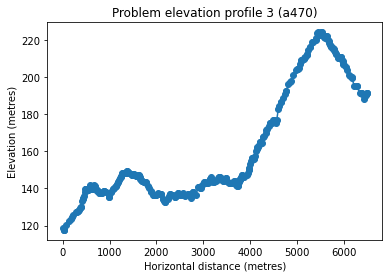

label: slp+weakcont
smp: 1.0
slope: 2.66
cont: 1.33
ang: inf
R: 0.9693695794211739
loglik: -4798.146075389966
coeff: 0.8943698145278741
int: 0.2975627747438674
ec/len err: 0.00973442821787501
min outlier: -66.59683886297401
max outlier: 43.003590636347695
a470 ec: 258.6170379594373


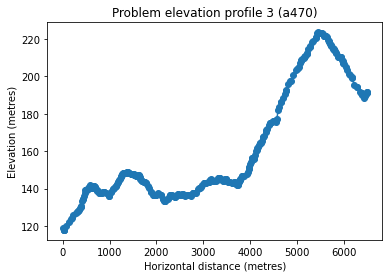

label: slp+weakcont
smp: 2.0408163265306123
slope: 2.66
cont: 1.33
ang: inf
R: 0.980514634209565
loglik: -4415.782265288469
coeff: 0.9760578560162705
int: 0.2918806665690923
ec/len err: 0.00826512215180867
min outlier: -43.982342112764
max outlier: 57.529402941574844
a470 ec: 213.80951584494613


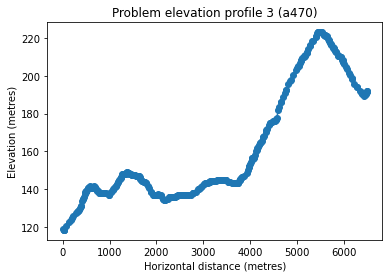

label: slp+weakcont
smp: 3.4489795918367347
slope: 2.66
cont: 1.33
ang: inf
R: 0.9827293452244185
loglik: -4313.45835312597
coeff: 1.0351905070891234
int: 0.43541278947659556
ec/len err: 0.008637672457683014
min outlier: -30.414560463169153
max outlier: 68.10224387656696
a470 ec: 188.350977451734


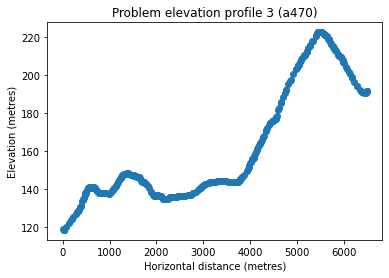

label: slp+weakcont
smp: 5.224489795918367
slope: 2.66
cont: 1.33
ang: inf
R: 0.9797547689135936
loglik: -4448.200533041847
coeff: 1.0740827599813527
int: 0.6587442945834319
ec/len err: 0.01000247783664431
min outlier: -23.007737156774738
max outlier: 74.1124052018877
a470 ec: 174.42695854344026


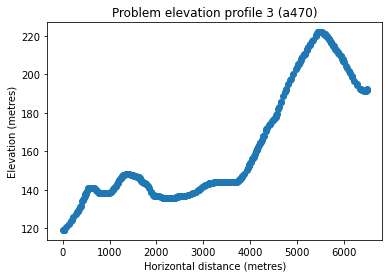

label: slp+weakcont
smp: 7.367346938775511
slope: 2.66
cont: 1.33
ang: inf
R: 0.9753939387392125
loglik: -4613.295883061575
coeff: 1.1049019978802208
int: 0.8836675643481184
ec/len err: 0.01157224060230182
min outlier: -18.259773607944652
max outlier: 76.77094974289328
a470 ec: 165.06088556160563


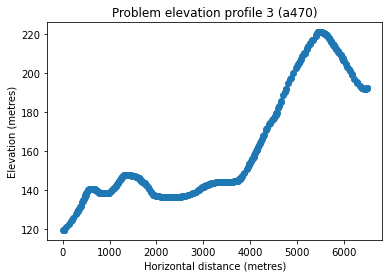

label: slp+weakcont
smp: 9.877551020408163
slope: 2.66
cont: 1.33
ang: inf
R: 0.9699684257398472
loglik: -4781.5051664609855
coeff: 1.1283607770060498
int: 1.1138653651206818
ec/len err: 0.013095909492070098
min outlier: -16.20204862856771
max outlier: 77.48148403679716
a470 ec: 158.60446667703877


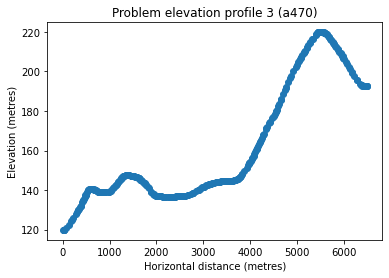

label: slp+weakcont
smp: 12.755102040816325
slope: 2.66
cont: 1.33
ang: inf
R: 0.9639990189061186
loglik: -4934.097509056275
coeff: 1.145818909947969
int: 1.3456315180288625
ec/len err: 0.014578629618854507
min outlier: -18.291094115900222
max outlier: 78.10416523411388
a470 ec: 151.90079596250834


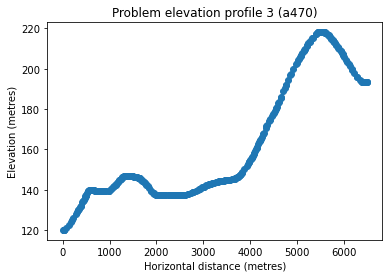

label: slp+weakcont
smp: 16.0
slope: 2.66
cont: 1.33
ang: inf
R: 0.9576933168760662
loglik: -5069.502214401082
coeff: 1.1633638073536314
int: 1.545431936723249
ec/len err: 0.015967850699564447
min outlier: -20.58821992185713
max outlier: 78.8413344183829
a470 ec: 143.07981754721663


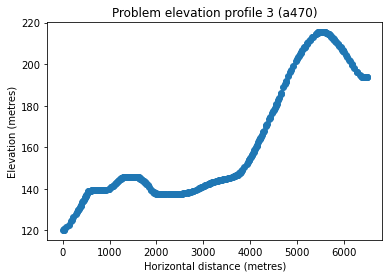

label: slp+weakcont
smp: 19.612244897959187
slope: 2.66
cont: 1.33
ang: inf
R: 0.9505588928368766
loglik: -5199.773586294708
coeff: 1.1817159345424246
int: 1.7346241734265853
ec/len err: 0.01729433866302552
min outlier: -23.539410326347976
max outlier: 79.97266686782051
a470 ec: 133.3769797808048


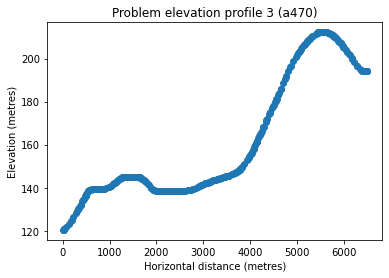

label: slp+weakcont
smp: 23.591836734693874
slope: 2.66
cont: 1.33
ang: inf
R: 0.9438374995465495
loglik: -5305.930635201411
coeff: 1.1980870604789706
int: 1.8955693711077695
ec/len err: 0.01843146628622239
min outlier: -26.47729745553356
max outlier: 80.38990306263248
a470 ec: 123.85206325669374


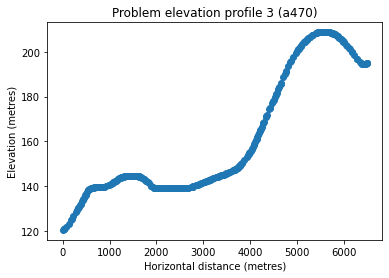

label: slp+weakcont
smp: 27.93877551020408
slope: 2.66
cont: 1.33
ang: inf
R: 0.9362080422009945
loglik: -5411.599707353274
coeff: 1.2143757567482896
int: 2.043681709598652
ec/len err: 0.019522369560655332
min outlier: -29.409129169914323
max outlier: 80.42457359472827
a470 ec: 113.67650671042328


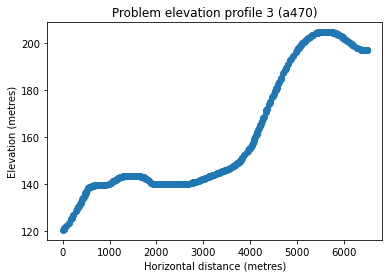

label: slp+weakcont
smp: 32.6530612244898
slope: 2.66
cont: 1.33
ang: inf
R: 0.9252605724768943
loglik: -5542.319906789862
coeff: 1.2456085948275035
int: 2.167463284233107
ec/len err: 0.02065155950327138
min outlier: -34.72027706941138
max outlier: 83.43901837172277
a470 ec: 98.75709052099126


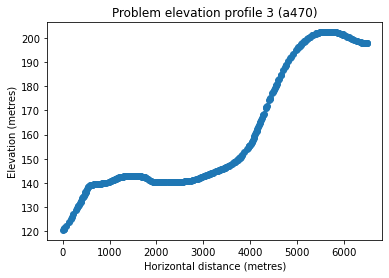

label: slp+weakcont
smp: 37.73469387755102
slope: 2.66
cont: 1.33
ang: inf
R: 0.9167454705438653
loglik: -5630.883490300998
coeff: 1.2559073559655134
int: 2.2936511887417996
ec/len err: 0.02151376375424438
min outlier: -37.59614013279942
max outlier: 90.75800978822346
a470 ec: 90.6378507580327


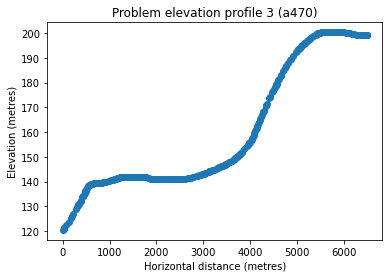

label: slp+weakcont
smp: 43.18367346938775
slope: 2.66
cont: 1.33
ang: inf
R: 0.905625664415919
loglik: -5733.216868632322
coeff: 1.2743716142143058
int: 2.4372693704687816
ec/len err: 0.02237278932063709
min outlier: -41.793778965809835
max outlier: 98.03617669920946
a470 ec: 82.79088608977806


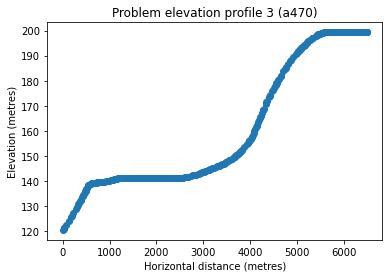

label: slp+weakcont
smp: 49.0
slope: 2.66
cont: 1.33
ang: inf
R: 0.8984146197194828
loglik: -5792.999225802309
coeff: 1.2781777590714019
int: 2.5406946832717656
ec/len err: 0.0229500903683093
min outlier: -44.02154812667756
max outlier: 105.08791266643831
a470 ec: 79.34337157328835


In [27]:
sensitivity(slope=2.66,cont=2.66/2,label="slp+weakcont")


In [25]:
sensitivity(slope=2.66,pitch=1.28,label="slp+pitch2")
#sensitivity(slope=2.66,cont=2.66,pitch=1.28*2,label="slp+cont+weakpitch2")
sensitivity(slope=2.66,label="slope2")
sensitivity(cont=2.66,label="cont2")
sensitivity(pitch=1.28,label="pitch2")
sensitivity(slope=2.66,cont=2.66,label="slp+cont2")
sensitivity(slope=2.66,cont=2.66,pitch=1.28,label="all2")
#sensitivity(slope=2.66,pitch=1.28*2,label="slp+weakpitch2")





KeyboardInterrupt: 

Max loglik for slope2: -4308.044 for smp=5.224489796
Min loglik for slope2: -5250.336 for smp=49.0
Max loglik for slp+weakcont: -4313.458 for smp=3.4489795918367347
Min loglik for slp+weakcont: -5792.999 for smp=49.0
Max loglik for cont2: -4336.738 for smp=7.367346939
Min loglik for cont2: -5184.489 for smp=49.0
Max loglik for pitch2: -5098.313 for smp=37.73469388
Min loglik for pitch2: -5210.762 for smp=27.93877551
Max loglik for slp+cont2: -4325.400 for smp=5.224489796
Min loglik for slp+cont2: -5470.287 for smp=49.0
Max loglik for slp+pitch2: -4964.485 for smp=5.224489796
Min loglik for slp+pitch2: -5213.084 for smp=32.65306122
Max loglik for all2: -4598.817 for smp=49.0
Min loglik for all2: -5200.103 for smp=37.73469388


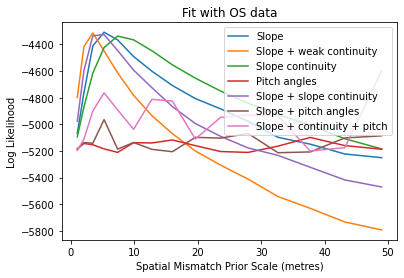

Max R for slope2: 0.983 for smp=5.224489796
Min R for slope2: 0.947 for smp=49.0
Max R for slp+weakcont: 0.983 for smp=3.4489795918367347
Min R for slp+weakcont: 0.898 for smp=49.0
Max R for cont2: 0.982 for smp=7.367346939
Min R for cont2: 0.951 for smp=49.0
Max R for pitch2: 0.956 for smp=37.73469388
Min R for pitch2: 0.950 for smp=27.93877551
Max R for slp+cont2: 0.982 for smp=5.224489796
Min R for slp+cont2: 0.932 for smp=49.0
Max R for slp+pitch2: 0.963 for smp=5.224489796
Min R for slp+pitch2: 0.950 for smp=32.65306122
Max R for all2: 0.976 for smp=49.0
Min R for all2: 0.951 for smp=37.73469388


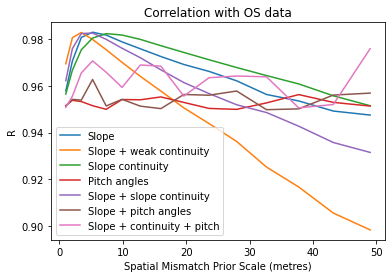

Max coeff for slope2: 1.150 for smp=49.0
Min coeff for slope2: 0.968 for smp=3.448979592
Max coeff for slp+weakcont: 1.278 for smp=49.0
Min coeff for slp+weakcont: 1.035 for smp=3.4489795918367347
Max coeff for cont2: 1.200 for smp=49.0
Min coeff for cont2: 0.932 for smp=3.448979592
Max coeff for pitch2: 0.829 for smp=37.73469388
Min coeff for pitch2: 0.795 for smp=27.93877551
Max coeff for slp+cont2: 1.198 for smp=49.0
Min coeff for slp+cont2: 0.998 for smp=3.448979592
Max coeff for slp+pitch2: 0.859 for smp=5.224489796
Min coeff for slp+pitch2: 0.793 for smp=32.65306122
Max coeff for all2: 0.928 for smp=49.0
Min coeff for all2: 0.799 for smp=37.73469388


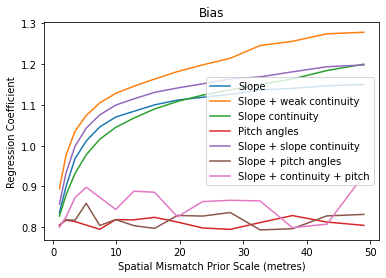

Max int for slope2: 1.937 for smp=49.0
Min int for slope2: 0.240 for smp=3.448979592
Max int for slp+weakcont: 2.541 for smp=49.0
Min int for slp+weakcont: 0.435 for smp=3.4489795918367347
Max int for cont2: 1.576 for smp=49.0
Min int for cont2: 0.276 for smp=3.448979592
Max int for pitch2: 0.458 for smp=27.93877551
Min int for pitch2: 0.404 for smp=37.73469388
Max int for slp+cont2: 2.236 for smp=49.0
Min int for slp+cont2: 0.305 for smp=3.448979592
Max int for slp+pitch2: 0.458 for smp=32.65306122
Min int for slp+pitch2: 0.347 for smp=5.224489796
Max int for all2: 0.452 for smp=37.73469388
Min int for all2: 0.240 for smp=49.0


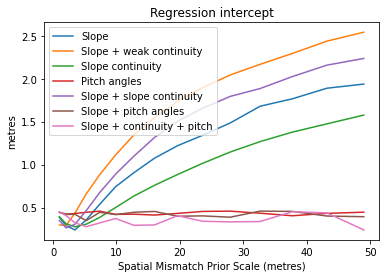

Max ec/len err for slope2: 0.019 for smp=49.0
Min ec/len err for slope2: 0.009 for smp=3.448979592
Max ec/len err for slp+weakcont: 0.023 for smp=49.0
Min ec/len err for slp+weakcont: 0.009 for smp=3.4489795918367347
Max ec/len err for cont2: 0.017 for smp=49.0
Min ec/len err for cont2: 0.008 for smp=5.224489796
Max ec/len err for pitch2: 0.012 for smp=27.93877551
Min ec/len err for pitch2: 0.011 for smp=37.73469388
Max ec/len err for slp+cont2: 0.021 for smp=49.0
Min ec/len err for slp+cont2: 0.008 for smp=3.448979592
Max ec/len err for slp+pitch2: 0.012 for smp=32.65306122
Min ec/len err for slp+pitch2: 0.011 for smp=5.224489796
Max ec/len err for all2: 0.012 for smp=37.73469388
Min ec/len err for all2: 0.009 for smp=49.0


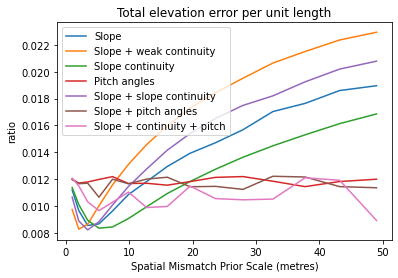

Max min outlier for slope2: -14.560 for smp=19.6122449
Min min outlier for slope2: -44.427 for smp=3.448979592
Max min outlier for slp+weakcont: -16.202 for smp=9.877551020408164
Min min outlier for slp+weakcont: -44.022 for smp=49.0
Max min outlier for cont2: -17.742 for smp=27.93877551
Min min outlier for cont2: -55.650 for smp=3.448979592
Max min outlier for pitch2: -80.817 for smp=37.73469388
Min min outlier for pitch2: -83.797 for smp=23.59183673
Max min outlier for slp+cont2: -15.276 for smp=12.75510204
Min min outlier for slp+cont2: -37.078 for smp=3.448979592
Max min outlier for slp+pitch2: -76.478 for smp=5.224489796
Min min outlier for slp+pitch2: -83.739 for smp=16.0
Max min outlier for all2: -55.385 for smp=49.0
Min min outlier for all2: -83.677 for smp=37.73469388


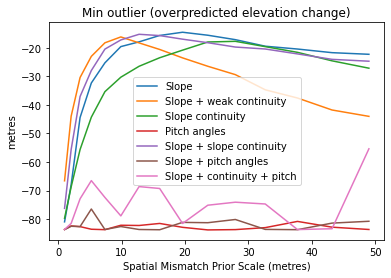

Max max outlier for slope2: 80.120 for smp=49.0
Min max outlier for slope2: 45.058 for smp=3.448979592
Max max outlier for slp+weakcont: 105.088 for smp=49.0
Min max outlier for slp+weakcont: 68.102 for smp=3.4489795918367347
Max max outlier for cont2: 77.910 for smp=49.0
Min max outlier for cont2: 50.796 for smp=3.448979592
Max max outlier for pitch2: 44.214 for smp=5.224489796
Min max outlier for pitch2: 42.568 for smp=37.73469388
Max max outlier for slp+cont2: 81.380 for smp=49.0
Min max outlier for slp+cont2: 59.860 for smp=3.448979592
Max max outlier for slp+pitch2: 43.924 for smp=9.87755102
Min max outlier for slp+pitch2: 39.526 for smp=5.224489796
Max max outlier for all2: 43.970 for smp=43.18367347
Min max outlier for all2: 37.308 for smp=7.367346939


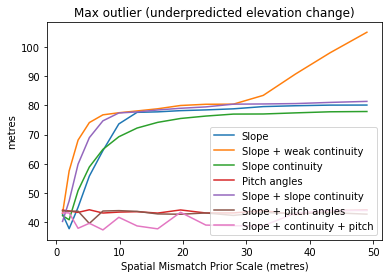

Max a470 ec for slope2: 214.558 for smp=3.448979592
Min a470 ec for slope2: 138.128 for smp=49.0
Max a470 ec for slp+weakcont: 188.351 for smp=3.4489795918367347
Min a470 ec for slp+weakcont: 79.343 for smp=49.0
Max a470 ec for cont2: 236.575 for smp=3.448979592
Min a470 ec for cont2: 134.547 for smp=49.0
Max a470 ec for pitch2: 312.360 for smp=27.93877551
Min a470 ec for pitch2: 296.191 for smp=37.73469388
Max a470 ec for slp+cont2: 202.141 for smp=3.448979592
Min a470 ec for slp+cont2: 115.348 for smp=49.0
Max a470 ec for slp+pitch2: 312.790 for smp=32.65306122
Min a470 ec for slp+pitch2: 280.857 for smp=5.224489796
Max a470 ec for all2: 310.708 for smp=37.73469388
Min a470 ec for all2: 237.280 for smp=49.0


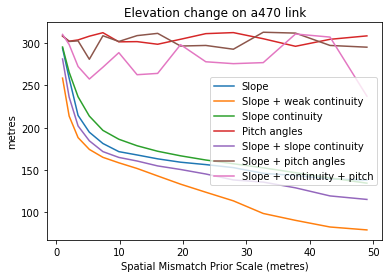

In [29]:
models = [("slope2","Slope"),
          ("slp+weakcont","Slope + weak continuity"),
         ("cont2","Slope continuity"),
         ("pitch2","Pitch angles"),
         ("slp+cont2","Slope + slope continuity"),
         ("slp+pitch2","Slope + pitch angles"),
         #("slp+cont+weakpitch2","Slope + continuity + weak pitch"),
         ("all2","Slope + continuity + pitch")]
         #("slp+weakpitch2","Slope + weak pitch") ]

def senstest(column,ylabel,title,legend=True):
    plt.figure()
    df = pd.read_csv("sensitivity3.csv")
    for key,label in models:
        model = df[df.label==key]
        plt.plot(model.smp,model[column],label=label)
        model = model[model.smp>3]
        maxrow = model[model[column]==model[column].max()]
        minrow = model[model[column]==model[column].min()]
        print(f"Max {column} for {key}: {float(maxrow[column]):.3f} for smp={float(maxrow.smp)}")
        print(f"Min {column} for {key}: {float(minrow[column]):.3f} for smp={float(minrow.smp)}")
    plt.xlabel("Spatial Mismatch Prior Scale (metres)")
    plt.ylabel(ylabel)
    if legend:
        plt.legend()
    plt.title(title)
    plt.show()

    
senstest("loglik","Log Likelihood","Fit with OS data")
senstest("R","R","Correlation with OS data")
senstest("coeff","Regression Coefficient","Bias")
senstest("int","metres","Regression intercept")
senstest("ec/len err","ratio","Total elevation error per unit length")
senstest("min outlier","metres","Min outlier (overpredicted elevation change)")
senstest("max outlier","metres","Max outlier (underpredicted elevation change)")
senstest("a470 ec","metres","Elevation change on a470 link")
#senstest("ncn ec","metres","Elevation change on NCN link",True)


In [ ]:
def plot_single(geom,label,fmt="",linecolor=""):
    zs = [geom.coords[0][2]]
    xs = [0]
    for (x1,y1,z1),(x2,y2,z2) in  pairwise(list(geom.coords)):
        xs += [xs[-1] + ((y2-y1)**2+(x2-x1)**2)**0.5]
        zs += [z2]
    #plt.scatter(xs,zs,label=label)
    if linecolor:
        plt.plot(xs,zs,fmt,label=label,color=linecolor)
    else:
        plt.plot(xs,zs,fmt,label=label)
    
def plot_profiles(which,smps,sps=90,scps=np.inf,paps=np.inf,label="",fmt="",linecolor=""):
    if which=="bigsweir":
        input_net = "finaltest"
        fid=1172
        idfield="ID"
    elif which=="bulwark":
        input_net = "bulwark"
        fid=1099
        idfield="fid"
    else:
        assert False
    
    draped_net_filename = test_drape(input_net,smps,sps,scps,paps,refresh=False)
    draped_net = gp.read_file(draped_net_filename)
    link = draped_net[draped_net[idfield]==fid].geometry.iloc[0]
    plot_single(link,label=label,fmt=fmt,linecolor=linecolor)
    return elev_change(link)
    

    
def plot_model_list(models,which,title):
    plt.figure()
    print(title)
    for key,modelname,smp,sps,cont,ang,fmt in models:
        ec=plot_profiles(which,smp,sps,cont,ang,label=modelname,fmt=fmt,linecolor=None)
        print(f"ec for {modelname} = {ec}")
    plot_profiles(which,0,90,np.inf,np.inf,label="Simple drape",fmt=":",linecolor="grey")
    plt.xlabel("Horizontal distance (metres)")
    plt.ylabel("Elevation (metres)")
    plt.title(title)
    plt.legend()
    plt.show()
    
# lowest smp good slope profiles for which overall model fit is good
models = [("slope","Slope (5m)",5,2.66,np.inf,np.inf,"-b"),
          ("slope","Slope (7m) ††",7,2.66,np.inf,np.inf,"--b"),
         ("slope","Slope (50m) ††",50,2.66,np.inf,np.inf,"-.b")]

plot_model_list(models,"bigsweir","Problem elevation profile 1 (Riverside track)")
plot_model_list(models,"bulwark","Problem elevation profile 2 (National Cycle Network)")

models = [("cont","Slope continuity (5m)",5,90,2.66,np.inf,"-C1"),
          ("cont","Slope continuity (16m) ††",16,90,2.66,np.inf,"--C1")]

#plot_model_list(models,"bigsweir","Problem elevation profile 1 (Riverside track)")
#plot_model_list(models,"bulwark","Problem elevation profile 2 (National Cycle Network)")

#models = [("slp+cont","Slope + slope continuity",16,2.66,0.058,np.inf),
#         ("slp+cont","Slope + slope continuity",5,2.66,0.058,np.inf)]

plot_model_list(models,"bigsweir","Problem elevation profile 1 (Riverside track)")
plot_model_list(models,"bulwark","Problem elevation profile 2 (National Cycle Network)")

models = [("pitch","Pitch angles (20m)",20,90,np.inf,1.28,"-g"),
         ("slp+pitch","Slope + pitch angles (7m)",7,2.66,np.inf,1.28,"-C4")]

# other profiles
         
#         ("slp+cont+weakpitch","Slope + continuity + weak pitch",37,2.66,0.058,2.6) ]

plot_model_list(models,"bigsweir","Problem elevation profile 1 (Riverside track)")
plot_model_list(models,"bulwark","Problem elevation profile 2 (National Cycle Network)")

models = [
          ("slp+cont+pitch","Slope + continuity + pitch (24m)",24,2.66,2.66,1.28,"-C5") ]


plot_model_list(models,"bigsweir","Problem elevation profile 1 (Riverside track)")
plot_model_list(models,"bulwark","Problem elevation profile 2 (National Cycle Network)")
